# Illustration of the Problem
![](MountainCar.png)

In [25]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
from torch import nn
from collections import deque
import random

#Test out environment and grab state/action space parameters
env = gym.make('MountainCar-v0')
n_actions = env.action_space.n
shape_obs = env.observation_space.shape
env.close()
#Action must be 0 (left), 1 (nothing), or 2 (right)

#Define initial/default parameters
class iparams: #initial parameters
    def __init__(self):
        #default hyperparameters
        self.buffersize = int(1E6) #Max Number of data points stored in buffer
        self.batchsize = 128 #BatchSize
        self.shape_obs = shape_obs
        self.n_actions = n_actions
        self.nH = [120,120,120]
        self.nA = n_actions
        self.nS = shape_obs[0]
        self.nC = 32 #Dimensionality of RND Network Code
        self.gamma = 0.99 #Time discount factor
        self.lr = 0.001 #Adam Optimizer Learning Rate


params = iparams()

#My favorite print function - repeats commands, doesn't always work with PyTorch
def printo(string):
    print(string,eval(string))

#Plotting mountain car trajectory from observations
def plot_trajectory(lst_obs):
    obs_vec = np.array(lst_obs)
    plt.figure(figsize=(10,3))
    time_addition = np.array(range(np.shape(obs_vec)[0]))/500
    default = np.array(range(1000))/1000*1.8-1.2
    plt.plot(obs_vec[:,0],np.sin(3*obs_vec[:,0])+time_addition,'.',
        label='Cart Trajectory')
    plt.plot(default,np.sin(3*default),label='Ground')
    plt.xlim([-1.2,0.6])
    plt.ylim([-1,1.1])
    plt.xlabel('Horizontal Position')
    plt.ylabel('Vertical with Time Addition')
    plt.legend()
    plt.show()

#Data buffer for storing data
class bufferobject:
    def __init__(self,params):
        self.buffersize=params.buffersize
        self.defaultbatch = params.batchsize
        self.index = 0
        #obs_dims = (self.buffersize,) + shape_obs
        #self.state = np.zeros(size=obs_dims)
        #self.actions = np
        #self.state = deque(maxlen=self.buffersize)
        #self.action = deque(maxlen=self.buffersize)
        #self.reward = deque(maxlen=self.buffersize)
        #self.nextstate = deque(maxlen=self.buffersize)
        self.experience = deque(maxlen=self.buffersize)

    def add(self,s,a,r,s_,d):
        #self.state.append(s)
        #self.action.append(a)
        #self.reward.append(r)
        #self.nextstate.append(s_)
        #self.index +=1
        self.experience.append([s,a,r,s_,d])
        self.index +=1

    
    def sample(self,batch = 32):
        #vec = range(min(self.index,self.buffersize))
        #ind = np.random.choice(a=vec,b=batchsize)
        #self.experience.sample
        K = min(self.index,self.buffersize,batch)
        samples = random.sample(self.experience, K)
        
        s,a,r,s_,d = zip(*samples)
        s = torch.tensor( s, dtype=torch.float)
        a = torch.tensor( a, dtype=torch.long).view(K, -1)
        r = torch.tensor( r, dtype=torch.float).view(K, -1)
        s_ = torch.tensor( s_, dtype=torch.float)
        d = torch.tensor( d, dtype=torch.float)
        return s,a,r,s_,d

    def sample_recent(self,batch = 32):
        K = min(self.index,self.buffersize,batch)
        samples = random.sample(self.experience[-K*2], K)
        
        s,a,r,s_,d = zip(*samples)
        s = torch.tensor( s, dtype=torch.float)
        a = torch.tensor( a, dtype=torch.long).view(K, -1)
        r = torch.tensor( r, dtype=torch.float).view(K, -1)
        s_ = torch.tensor( s_, dtype=torch.float)
        d = torch.tensor( d, dtype=torch.float)
        return s,a,r,s_,d


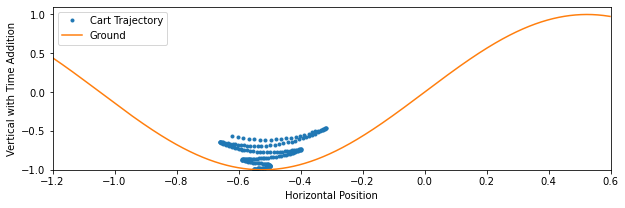

In [26]:
#Test Episode for Environment/Buffer
env = gym.make('MountainCar-v0')
s = env.reset()
buffer = bufferobject(params)
#printo('env.action_space')
#printo('env.observation_space')
#Action must be 0 (left), 1 (nothing), or 2 (right)
#observation, reward, done, _  = env.step(2) 
#printo('observation, reward, done')

lst_obs = []
d=False
while d==False:

    a = np.random.choice([0,1,2])
    s_, r, d, _ = env.step(a)
    buffer.add(s,a,r,s_,d)
    lst_obs.append(s)
    s =  s_
    _,actions,_,_,_ = buffer.sample(batch=5)
    #printo('actions')
plot_trajectory(lst_obs)
stest = s
env.close()

In [12]:
#Define Q network
class Qnet(torch.nn.Module):
    def __init__(self,params):
        super(Qnet, self).__init__()
        self.nS = params.nS
        self.nH = params.nH
        self.nA = params.nA
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(self.nS,self.nH[0]))
        for ind in range(len(self.nH)-1):
            self.layers.append(nn.Linear(self.nH[ind],self.nH[ind+1]))
        self.layers.append(nn.Linear(self.nH[-1],self.nA))

        self.optim = torch.optim.Adam(self.parameters(),lr=params.lr)

    def forward(self,x):
        #x should be a tensor of size (batch,nS)
        for ind in range(len(self.nH)-1):
            x = nn.functional.relu(self.layers[ind](x))
        x = self.layers[-1](x)
        return x


#Define Random Network Distillation (RND) network
class RNDnet(torch.nn.Module):
    def __init__(self,params):
        super(RNDnet, self).__init__()
        self.nS = params.nS
        self.nH = params.nH
        self.nA = params.nC
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(self.nS,self.nH[0]))
        for ind in range(len(self.nH)-1):
            self.layers.append(nn.Linear(self.nH[ind],self.nH[ind+1]))
        self.layers.append(nn.Linear(self.nH[-1],self.nA))

        self.optim = torch.optim.Adam(self.parameters(),lr=params.lr)

    def forward(self,x):
        #x should be a tensor of size (batch,nS)
        for ind in range(len(self.nH)-1):
            x = nn.functional.relu(self.layers[ind](x))
        x = self.layers[-1](x)
        return x

# Separated Q function inputs and selection from the action sampling 
# I don't love the proportional implementation since the proportional involves tuned constants to make the softmax work, 
# but it choose_action does select an action with sampling functionality
def Qs_(state,Qnet):
    with torch.no_grad():
        Qs = Qnet(state)
    return Qs

def Qs_mix(state,Qnet1,Qnet2,alpha=0.9):
    with torch.no_grad():
        Qs1 = Qnet1(state)
        Qs2 = Qnet2(state)
        Qmix = Qs1*alpha + Qs2*(1-alpha)
    return Qmix

def choose_action(Qs,mode='epsgreedy', epsilon=0.1):
    #Qs should be the vector of state values
    #state should be a tensor of size (1,nS)
    sample = np.random.uniform()
    if mode.casefold() == 'epsgreedy'.casefold():
        if sample > epsilon:
            action = torch.argmax(Qs)
        else:
            action = np.random.choice(np.array(range(len(Qs))))
            action = torch.tensor(action)
    if mode.casefold() == 'proportional'.casefold():
            Qs_norm = Qs*5/(torch.max(Qs)-torch.min(Qs))
            probs = torch.nn.Softmax(dim=0)(Qs_norm)
            dist = torch.distributions.categorical.Categorical(probs=probs)
            action = dist.sample()
    if mode.casefold() == 'optimal'.casefold():
        action = torch.argmax(Qs)
    #returns a tensor of size (1)
    return action

# def choose_action(state,Qnet1,Qnet2,alpha=0.9,mode='epsgreedy',epsilon=0.1)
#     with torch.no_grad():
#         Qs1 = Qnet1(state)
#         Qs2 = Qnet2(state)
#         Qmix = Qs1*alpha + Qs2(1-alpha)
#         sample = np.random.uniform()
#         if mode.casefold() == 'epsgreedy'.casefold():
#             if sample > epsilon:
#                 action = torch.argmax(Qs)
#             else:
#                 action = np.random.choice(np.array(range(params.nA)))
#                 action = torch.tensor(action)
#         if mode.casefold() == 'proportional'.casefold():
#                 Qs_norm = Qs*5/(torch.max(Qs)-torch.min(Qs))
#                 probs = torch.nn.Softmax(dim=0)(Qs_norm)
#                 dist = torch.distributions.categorical.Categorical(probs=probs)
#                 action = dist.sample()
#         if mode.casefold() == 'optimal'.casefold():
#             action = torch.argmax(Qs)
#     #returns a tensor of size (1)
#     return action

def updateRND(RNDnetwork_target,RNDnetwork2,params,recent_batch):
    s,a,r,s_,d = recent_batch
    with torch.no_grad():
        RND_target = RNDnetwork_target(s)
    RND_pred = RNDnetwork2(s)
    loss = torch.mean(torch.sqrt((RND_target-RND_pred)**2))

    Qnetwork.optim.zero_grad()
    loss.backward()
    Qnetwork.optim.step()

    return Qnetwork, loss
    

def updateQ(Qnetwork,params,batch,rewardtype='standard'):
    #state should be a tensor of size (batchsize,nS)
    s,a,r,s_,d = batch
    if reward.casefold() == 'RND'.casefold():
        r = RND_reward(s,a)
    Qpreds = Qnetwork(s)
    #action number to onehot encoding
    a_mask = torch.nn.functional.one_hot(a,num_classes=params.nA).squeeze(dim=1)

    Qpred =torch.max(Qpreds*a_mask,dim=1,keepdim=True)[0]
    Qpred = Qpred.squeeze()

    Qtarget = (r + params.gamma*torch.max(Qnetwork(s_),dim=1,keepdim=True)[0])
    Qtarget = Qtarget.squeeze()
    
    loss = torch.mean((Qpred-Qtarget)**2)
    Qnetwork.optim.zero_grad()
    loss.backward()
    Qnetwork.optim.step()

    return Qnetwork, loss
   


#s2 = np.stack((s,s_,s_),axis=0)
Q1 = Qnet(params)
#x = Q.forward(s)
#x = Q.forward(s2)

#Make sure action selection works
Q2 = Qnet(params)
state = torch.tensor(stest).unsqueeze(dim=0)
#printo('state'); printo('state.size()')
for _ in range(15):
    #Qs = Qs_(state,Q1)
    Qs = Qs_mix(state,Q1,Q2,alpha=0.9)
    action = choose_action(Qs,epsilon=0.1,mode='proportional')
    printo('action')    



#Grab samples from buffer
s,a,r,s_,d = buffer.sample(batch=1)
#Modify Reward
#Recompile
batch_ = s,a,r,s_,d
Q1, loss = updateQ(Q1,params,batch_)



action tensor([1])
action tensor([0])
action tensor([1])
action tensor([1])
action tensor([2])
action tensor([1])
action tensor([0])
action tensor([1])
action tensor([1])
action tensor([2])
action tensor([1])
action tensor([0])
action tensor([1])
action tensor([1])
action tensor([2])


In [177]:
#s,a,r,s_,d = buffer.sample(batch=5)
#printo('s,a,r,s_,d')
#batch_ = buffer.sample(batch=5)
#s,a,r,s_,d = batch_
#printo('s')
#printo('a')
#printo('r')
#printo('s_')
#printo('d')
#batch__ = s,a,r,s_,d
#printo('batch__')
#ss,_,_,_,_ = batch__
#printo('ss')

a = torch.randn(4, 4)
print(a)
#(torch.max(a, 1))
b,c = torch.max(a,1)
print(b)

#Grab samples from buffer
s,a,r,s_,d = buffer.sample(batch=1)
#Modify Reward
#Recompile
batch_ = s,a,r,s_,d
Q, loss = updateQ(Q,params,batch_)

tensor([[ 0.9309,  0.3015, -0.1338,  0.5633],
        [ 0.2130,  1.4974, -0.1751,  1.3109],
        [ 0.4376,  0.0556, -0.2118, -0.1233],
        [-0.0375, -1.4372,  1.4912, -2.7417]])
tensor([0.9309, 1.4974, 0.4376, 1.4912])
a tensor([[1]]) a.size torch.Size([1, 1])
a_mask tensor([[0, 1, 0]]) a_mask.size() torch.Size([1, 3])
r tensor([[-1.]]) r.size() torch.Size([1, 1])
Qpreds.size() torch.Size([1, 3])
Qpred.size() torch.Size([])
Qtarget.size() torch.Size([])
loss tensor(1.0037, grad_fn=<MeanBackward0>)


In [ ]:
aa = np.exp(6/12)
bb = np.exp(-6/12)
print(aa,bb)
print(aa/(aa+bb))

1.6487212707001282 0.6065306597126334
0.731058578630005


In [ ]:
mode='epsgreedy'
mode.casefold() == 'ePsgreedy'.casefold()

True

In [ ]:
env = gym.make('MountainCar-v0')
actionspace = env.action_space
observationspace = env.observation_space
env.close()

printo('actionspace')
printo('observationspace')
printo('env.observation_space.shape')
printo('env.action_space.n')
dims = env.observation_space.shape
dims = (4,) + dims
printo('dims')
a = np.zeros(shape = (dims))
print(a)


testdeque = deque(maxlen=5)
b = np.array([[3,4],[6,7]])
c = np.array([1,2])
testdeque.append(b)
testdeque.append(c)
print(testdeque)

#d = np.random.choice(np.array(range(10)))
d = np.random.choice(range(10))
printo('d')

printo('testdeque(0:1)')

actionspace Discrete(3)
observationspace Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
env.observation_space.shape (2,)
env.action_space.n 3
dims (4, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
deque([array([[3, 4],
       [6, 7]]), array([1, 2])], maxlen=5)
d 9


SyntaxError: invalid syntax (<string>, line 1)

SyntaxError: invalid syntax (4267963725.py, line 1)